<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Assignment12/Session12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!ls


cutout-random-erasing  keras-one-cycle	__pycache__  sample_data


In [1]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


In [0]:
class CyclicLR(Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
                
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
            

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [5]:
print (num_classes)
print (num_train)
print (train_features.shape)
print (test_features.shape)

10
50000
(50000, 32, 32, 3)
(10000, 32, 32, 3)


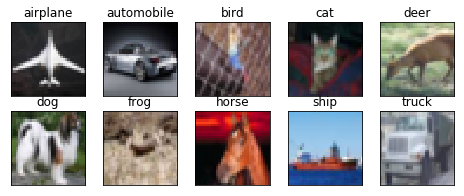

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [10]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
!git clone https://github.com/yu4u/cutout-random-erasing

fatal: destination path 'cutout-random-erasing' already exists and is not an empty directory.


In [24]:
!cp cutout-random-erasing/* .
!ls

cifar10_resnet.py      example.ipynb	LICENSE		  README.md
cutout-random-erasing  example.png	__pycache__	  sample_data
example2.png	       keras-one-cycle	random_eraser.py


In [0]:
X_train = train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

In [12]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))



W0724 14:23:12.567901 139838103525248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0724 14:23:12.588660 139838103525248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 14:23:12.591621 139838103525248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 14:23:12.632462 139838103525248 deprecation_wrapper.py

In [13]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
from random_eraser import get_random_eraser
datagen = ImageDataGenerator(horizontal_flip=True,
                             featurewise_center=True, featurewise_std_normalization=True,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

testgen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
num_samples = X_train.shape[0]
batch_size=128

In [0]:
!git clone https://github.com/titu1994/keras-one-cycle

In [0]:
!cp keras-one-cycle/* .

In [0]:
from clr import LRFinder


lr_callback = LRFinder(num_samples, batch_size,
                       minimum_lr=1e-3, maximum_lr=1.,
                       # validation_data=(X_val, Y_val),
                       lr_scale='exp', save_dir='Lr/')

# Ensure that number of epochs = 1 when calling fit()
model1.fit_generator(testgen.flow(X_train, y_train, batch_size=batch_size), epochs=1, callbacks=[lr_callback], steps_per_epoch=num_samples// batch_size)

In [0]:
LRFinder.plot_schedule_from_file('Lr/', clip_beginning=10, clip_endding=5)

In [0]:
WEIGHT_DECAY_FACTORS = [1e-7, 3e-7, 3e-6]
for weight_decay in WEIGHT_DECAY_FACTORS:
    directory = 'weights/weight_decay/weight_decay-%s/' % str(weight_decay)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(x = lrs, y = losses, label='weight_decay=%0.7f' % weight_decay)

plt.title("Weight Decay")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [15]:
from keras.optimizers import SGD
# Compile the model
sgd = SGD(lr=0.000001, momentum=0.9, decay = (0.000125 * batch_size), nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0724 14:23:22.213223 139838103525248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
!ls


cifar10_resnet.py      example.ipynb	Lr		  README.md
clr.py		       example.png	plot_clr.py	  sample_data
cutout-random-erasing  keras-one-cycle	__pycache__
example2.png	       LICENSE		random_eraser.py


In [0]:
batch_size = 512
epochs = 100
max_lr = 0.5
base_lr = max_lr/10000
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35

iterations = round(num_samples/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


In [0]:
clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)
    
callbacks = [clr,
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True)]

In [18]:
hist = model1.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=testgen.flow(X_test, y_test, batch_size=batch_size), epochs=epochs, callbacks=callbacks, validation_steps=100, steps_per_epoch=num_samples// batch_size)

W0724 14:23:33.047969 139838103525248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 28s 292ms/step - loss: 1.9612 - acc: 0.3359 - val_loss: 6.5201 - val_acc: 0.2427

Epoch 00001: val_loss improved from inf to 6.52014, saving model to best_model.h5
Epoch 2/100
97/97 [==============================] - 25s 262ms/step - loss: 1.2785 - acc: 0.5574 - val_loss: 8.9788 - val_acc: 0.1436

Epoch 00002: val_loss did not improve from 6.52014
Epoch 3/100
97/97 [==============================] - 25s 253ms/step - loss: 1.0881 - acc: 0.6295 - val_loss: 2.2501 - val_acc: 0.4665

Epoch 00003: val_loss improved from 6.52014 to 2.25009, saving model to best_model.h5
Epoch 4/100
97/97 [==============================] - 25s 253ms/step - loss: 0.9662 - acc: 0.6761 - val_loss: 1.7238 - val_acc: 0.5332

Epoch 00004: val_loss improved from 2.25009 to 1.72375, saving model to best_model.h5
Epoch 5/100
97/97 [==============================] - 25s 254ms/step - loss: 0.8861 - acc: 0.7069 - val_loss: 1.2711 - val_acc: 0.6387

Epoch 00005: val_loss improved f

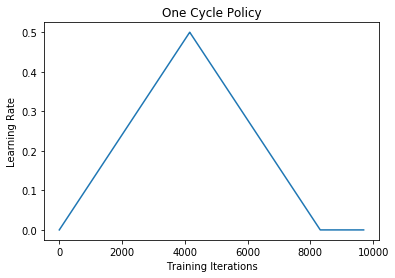

In [19]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

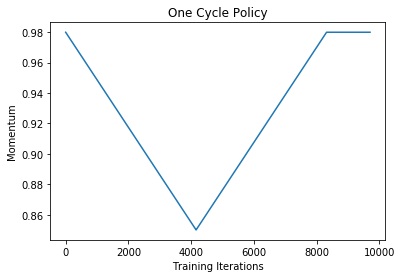

In [20]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

In [64]:
print(hist.history)

{'val_loss': [1.0198089004615216, 1.0240906367987432, 0.967516152434812, 0.889283581392759, 1.2894135728609968, 1.1832779993175107, 1.272220531748643, 1.0870360398413874, 1.0289836714577405, 0.9372158085112313], 'val_acc': [0.7702553593947037, 0.7704129886506935, 0.789328499369483, 0.8163167938931297, 0.7032629255989912, 0.7146122320302648, 0.6912831021437579, 0.7511927480916031, 0.7686790668348046, 0.7983133669609079], 'loss': [0.8632021445494432, 0.8553061667909827, 0.8547986724417218, 0.8533005260832233, 0.8545727072941557, 0.8570821177206018, 0.8518014726709164, 0.8520364660768506, 0.8405821290312955, 0.8440929101681457], 'acc': [0.8144230769230769, 0.8175930381394901, 0.8204603785308922, 0.8221045877637487, 0.819197144671285, 0.8211822264807171, 0.8232274622843745, 0.8235282322937455, 0.8268367019952548, 0.8275786012382433]}


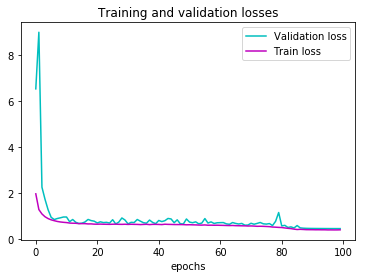

In [21]:
# Plot losses
val_loss = hist.history['val_loss']
loss = hist.history['loss']
plt.plot(range(len(val_loss)),val_loss,'c',label='Validation loss')
plt.plot(range(len(loss)),loss,'m',label='Train loss')

plt.title('Training and validation losses')
plt.legend()
plt.xlabel('epochs')
plt.show()

In [0]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('modelBest.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = testgen.flow(X_test, y_test), verbose=1,validation_steps=100,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, y_test, model1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, validation_steps=100, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ke

Epoch 1/100
390/390 [==============================] - 13s 34ms/step - loss: 15.0466 - acc: 0.1023 - val_loss: 14.4592 - val_acc: 0.1062

Epoch 00001: val_acc improved from -inf to 0.10625, saving model to modelBest.h5
Epoch 2/100
390/390 [==============================] - 12s 30ms/step - loss: 14.5221 - acc: 0.0998 - val_loss: 14.5022 - val_acc: 0.1003

Epoch 00002: val_acc did not improve from 0.10625
Epoch 3/100
185/390 [=============>................] - ETA: 5s - loss: 14.5093 - acc: 0.0998

KeyboardInterrupt: ignored

## Max training and test accuracy

In [0]:
print("Training Accuracy:")
print(max(model_info.history['acc']))
print("Test Accuracy:")
print(max(model_info.history['val_acc']))

Training Accuracy:
0.9077438242281711
Test Accuracy:
0.895625


In [0]:
from keras.models import load_model
modelBest = load_model("modelBest.h5")

##Model Evaluate for best model

In [0]:
modelBest.evaluate_generator(testgen.flow(X_test, y_test), steps=32)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[0.4871593019925058, 0.876953125]

In [0]:
test_generator = testgen.flow(X_test, y_test,
  shuffle=False)
y_pred = modelBest.predict_generator(test_generator, steps=100)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
